### Imports

In [94]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import statsmodels.tsa.stattools as ts 
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt
import random
import time
import matplotlib.dates as mdates

### Initalizing Data Window

In [96]:
end = dt.date.today() - dt.timedelta(days=1)
start = end - dt.timedelta(days=365*4)

### Define Helper Functions

In [97]:
def get_data(stock, start, end):
  df = yf.download(stock, start, end)
  return df['Adj Close'], df['Volume']

In [98]:
def get_sp():
  data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
  df = data[0]
  stocks = df['Symbol'].tolist()
  for i in range(len(stocks)):
    if "."  in stocks[i]:
      stocks[i] = stocks[i].replace(".", "-")
  return stocks[:50]

In [99]:
 ### Define the Cointegration tester function
def coint_test(A, B):
  if A.name != B.name:
    if pearsonr(A,B).pvalue < 0.02:
      if linregress(A,B).rvalue ** 2 > 0.9:
        if ts.coint(A,B)[1]  < 0.02:
            return [A.name, B.name]


In [100]:
# Find Cointegrated Pairs from DataFrame

def find_pairs(df):
  tickers = df.columns.tolist()
  coint_list = []
  for i in range(len(tickers)):
    for j in range(i, len(tickers)):
      entry = coint_test(df[tickers[i]],df[tickers[j]])
      if entry != None:
        coint_list.append(entry)
    
    print(f"Found {len(coint_list)} after {i+1} Stocks")

  return coint_list

In [101]:
# Make a Seires with the 100 highest volume stocks
def find_highest_volumes(volumes,df):
  means = {}
  for i in volumes.columns:
    means[i] = volumes[i].mean()
  means = pd.Series(means)
  means.sort_values(ascending=False)
  means = means[:100]
  high_volume_data = pd.DataFrame()
  for i in means.index.tolist():
    high_volume_data[i] = df[i]

In [102]:
### Returns Train split of data set
def train(X):
  return X[:int(len(X)*0.7)]

In [103]:
### Returns Test split of data set
def test(X):
  return X[int(len(X)*0.7):]

### Define Chart Functions

In [104]:
### Make a heatmap grid to show findings

In [105]:
def dual_axis_chart(A,B,ax):
  ax.set_title(f"Price overlay of {A.name} and {B.name}")
  ax2 = ax.twinx()
  ax.plot(A, color='orange', label=f'{A.name}')
  ax2.plot(B, color='blue', label=f'{B.name}')
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
  ax.set_ylabel(f'{A.name} Price')
  ax2.set_ylabel(f'{B.name} Price')
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  ax.legend(fancybox=True, framealpha=0.5, loc=1)
  ax2.legend(fancybox=True, framealpha=0.5, loc=2)

In [106]:
def scatter_chart(A,B,ax):
  ax.scatter(train(A),train(B), color='blue', label='train data')
  ax.scatter(test(A),test(B), color='orange',label='test data')
  ax.set_xlabel(f'{A.name} price')
  ax.set_ylabel(f'{B.name} price')
  regression = linregress(A,B)
  a = regression.slope
  b=regression.intercept
  ax.plot(A, a* A + b,color='red')
  ax.set_title(f"R Squared: {round(regression.rvalue ** 2,2)}")
  ax.legend(fancybox=True, framealpha=0.5, loc=2)

In [107]:
def ratio_plot(A,B,ax):
  fig = plt.figure()
  ratio = A/B
  ax.plot(train(ratio), color='blue', label='Train Data')
  ax.plot(test(ratio), color='orange', label='Test Data')
  ax.set_title(f"Price Ratio of {A.name} and {B.name}")
  ax.legend(fancybox=True, framealpha=0.5, loc=1)
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

In [108]:
def zscore_plot(A, B,ax):
  ratio = A/B
  mavg_5 = ratio.rolling(5).mean()
  mavg_60 = ratio.rolling(60).mean()
  std_60 = ratio.rolling(60).std()
  zscore = (mavg_5 - mavg_60)/std_60
  ax.plot(zscore[60:], color='blue')
  ax.set_title(f"Z-Score plot of Price Ratio")
  ax.axhline(y=-0.5, color='red', linestyle='--')
  ax.axhline(y=0.5, color='red', linestyle='--', label='Buy Spread')
  ax.axhline(y=1, color='orange', label='Sell Spread')
  ax.axhline(y=-1, color='orange')
  ax.set_ylabel('Standard Deviation')
  ax.legend()
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

In [109]:
def buy_sell_signals(A, B, ax):
  ax.plot(A,color='blue',label=A.name)
  ax.plot(B,color='orange',label=B.name)
  ax.set_title(f"Buy and Sell Signals")

  ratio = A/B
  mavg_5 = ratio.rolling(5).mean()
  mavg_60 = ratio.rolling(60).mean()
  std_60 = ratio.rolling(60).std()
  zscore = (mavg_5 - mavg_60)/std_60


  buy = A.copy()
  sell = B.copy()
  buy[zscore>-1] = 0
  sell[zscore<1] = 0
  ax.plot(buy[60:], color='green', linestyle='None', marker='^', label='buy')
  ax.plot(sell[60:],color='red', linestyle='None', marker='^', label='sell')
  ax.set_ylim(min(A.min(), B.min()), max(A.max(), B.max()))
  ax.legend()
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=180))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


In [110]:
# Trade using a simple strategy
def trade(A, B):
  
  balance = []

  ratio = A/B
  mavg_5 = ratio.rolling(5).mean()
  mavg_60 = ratio.rolling(60).mean()
  std_60 = ratio.rolling(60).std()
  zscore = (mavg_5 - mavg_60)/std_60
    
  cash = 100
  A_shares = 0
  B_shares = 0
  for i in range(len(ratio)):
      if zscore[i] > 1:
          cash += A[i] - B[i] * ratio[i]
          A_shares -= 1
          B_shares += ratio[i]
      elif zscore[i] < -1:
          cash -= A[i] - B[i] * ratio[i]
          A_shares += 1
          B_shares -= ratio[i]
      elif abs(zscore[i]) < 0.75:
          cash += A[i] * A_shares + B[i] * B_shares
          A_shares = 0
          B_shares = 0
          
      balance.append(cash)
  return balance

In [111]:
def simulation_plot(A,B,ax):
  ax.set_title(f"Returns from last {len(A)} days using strategy")
  ax.plot(A.index, trade(A,B))
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=180))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))



In [112]:
def residual_plot(A, B, ax):
  res = A - B
  ax.set_title("Price Gap")
  ax.plot(train(res), color='blue')
  ax.plot(test(res), color = 'orange')
  ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

In [113]:
def make_subplot(A,B):
  fig, ax = plt.subplots(2,3, figsize=(15,10))
  fig.tight_layout(pad=5)
  fig.suptitle(f"{A.name} and {B.name} Cointegration Dashboard", fontsize=25, y=1.03)
  dual_axis_chart(A,B,ax[0][0])
  ratio_plot(A,B, ax[0][1])
  scatter_chart(A,B, ax[1][0])
  zscore_plot(A,B, ax[1][1])
  buy_sell_signals(test(A),test(B), ax[0,2])
  simulation_plot(test(A),test(B), ax[1][2])
  return fig

In [114]:
def summary_chart(A,B):
  fig, ax = plt.subplots(3,3, figsize=(15,15))
  fig.tight_layout(pad=5)
  fig.suptitle(f"{A.name} and {B.name} Summary plots", fontsize=25, y=1.01)
  residual_plot(A,B, ax[0][0])
  scatter_chart(A,B, ax[0][1])
  ratio_plot(A,B, ax[0][2])
  zscore_plot(train(A), train(B), ax[1][0])
  buy_sell_signals(train(A),train(B), ax[1][1])
  simulation_plot(train(A),train(B), ax[1][2])
  zscore_plot(test(A), test(B), ax[2][0])
  buy_sell_signals(test(A),test(B), ax[2][1])
  simulation_plot(test(A),test(B), ax[2][2])
  return fig

### Run Screener

In [115]:
 ### Download Adj Close and Volume Data
df, volume = get_data(get_sp(), start, end)
df = df.dropna(axis=1)
volume = volume.dropna(axis=1)

[*********************100%***********************]  50 of 50 completed


In [116]:
### Gets stock data with the 100 highest average trading volume
high_volume_data = find_highest_volumes(volume, df)

In [117]:
coint_list = find_pairs(train(df))

Found 0 after 1 Stocks
Found 0 after 2 Stocks
Found 0 after 3 Stocks
Found 1 after 4 Stocks
Found 1 after 5 Stocks
Found 2 after 6 Stocks
Found 2 after 7 Stocks
Found 2 after 8 Stocks
Found 5 after 9 Stocks
Found 5 after 10 Stocks
Found 9 after 11 Stocks
Found 11 after 12 Stocks
Found 11 after 13 Stocks
Found 11 after 14 Stocks
Found 11 after 15 Stocks
Found 11 after 16 Stocks
Found 11 after 17 Stocks
Found 11 after 18 Stocks
Found 12 after 19 Stocks
Found 12 after 20 Stocks
Found 12 after 21 Stocks
Found 12 after 22 Stocks
Found 12 after 23 Stocks
Found 12 after 24 Stocks
Found 12 after 25 Stocks
Found 12 after 26 Stocks
Found 12 after 27 Stocks
Found 12 after 28 Stocks
Found 12 after 29 Stocks
Found 12 after 30 Stocks
Found 12 after 31 Stocks
Found 12 after 32 Stocks
Found 12 after 33 Stocks
Found 12 after 34 Stocks
Found 12 after 35 Stocks
Found 12 after 36 Stocks
Found 12 after 37 Stocks
Found 12 after 38 Stocks
Found 12 after 39 Stocks
Found 12 after 40 Stocks
Found 12 after 41 St

In [118]:
### Displays how many cointegrated pairs were found
print(len(coint_list))

12


### Show Sample Charts

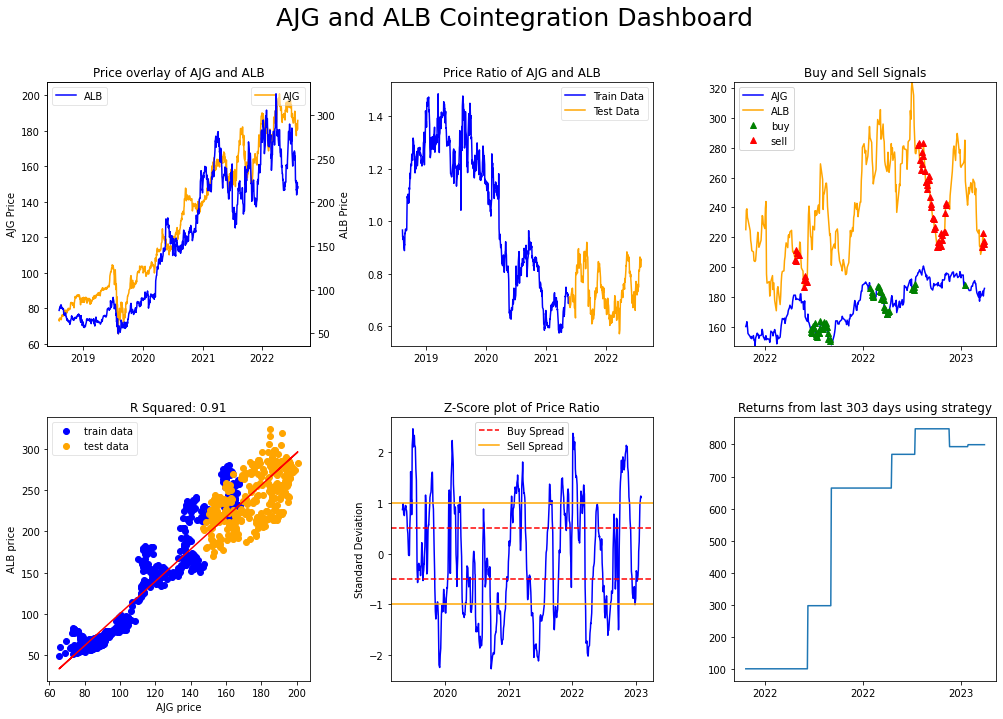

<Figure size 432x288 with 0 Axes>

In [119]:
i = random.choice(coint_list)
A, B = df[i[0]], df[i[1]]
plt = make_subplot(A,B)

In [120]:
#plt = summary_chart(A,B)

### Save Charts from List

In [121]:
!rm *

rm: cannot remove 'sample_data': Is a directory


In [123]:
"""
for pair in coint_list[:35]:
  A, B = df[pair[0]], df[pair[1]]
  fig = summary_chart(A,B)
  fig.savefig(f'{pair[0]} and {pair[1]} Cointegration Plot')
"""

"\nfor pair in coint_list[:35]:\n  A, B = df[pair[0]], df[pair[1]]\n  fig = summary_chart(A,B)\n  fig.savefig(f'{pair[0]} and {pair[1]} Cointegration Plot')\n  "

In [124]:
#!zip -r /content/file.zip /content/